## To Do

Clean up code:
    get my sqlite file
    filter by price and remove all duplicates
    get URLs 
    only run your code to get the vintages:
        run through all vintages instead of recommended 
        add taset prfile % ****
        price for bottles if there 
        

        

    

In [1]:
import os
import json
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pylab as plt
import requests
from bs4 import BeautifulSoup
import sqlite3
import re
from selenium import webdriver
from selenium.webdriver.common.by import By
import folium
import plotly.express as px
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

In [2]:
all_filtered_winebottle_v1 = pd.read_csv('all_filtered_winebottle_v1.csv')
all_filtered_winebottle_v1_sorted = all_filtered_winebottle_v1.sort_values(
    by=['WineType', 'Producer', 'year'],  
    ascending=[False, False, False]  
)
all_filtered_winebottle_v1

id                                   name_x        Country  \
0       172970038              È Jamu Zimbato Chianti 2021          Italy   
1       165847548              È Jamu Zimbato Chianti 2019          Italy   
2       164918292                       Áster Crianza 2020          Spain   
3       159738134                       Áster Crianza 2019          Spain   
4       143423814                       Áster Crianza 2016          Spain   
...           ...                                      ...            ...   
121200  168770279          100 Nails Ranch Pinot Noir 2020  United States   
121201  167314372          100 Nails Ranch Pinot Noir 2019  United States   
121202  168233793  100 Nails Ranch Cabernet Sauvignon 2020  United States   
121203  166756066  100 Nails Ranch Cabernet Sauvignon 2019  United States   
121204  166737907  100 Nails Ranch Cabernet Sauvignon 2018  United States   

                  Region         Producer            WineType    year  \
0                Chianti           È Jamu     Zimbato Chianti  2021.0   
1                Chianti           È Jamu     Zimbato Chianti  2019.0   
2       Ribera del Duero            Áster             Crianza  2020.0   
3       Ribera del Duero            Áster             Crianza  2019.0   
4       Ribera del Duero            Áster             Crianza  2016.0   
...                  ...              ...                 ...     ...   
121200     Central Coast  100 Nails Ranch          Pinot Noir  2020.0   
121201     Central Coast  100 Nails Ranch          Pinot Noir  2019.0   
121202       Paso Robles  100 Nails Ranch  Cabernet Sauvignon  2020.0   
121203       Paso Robles  100 Nails Ranch  Cabernet Sauvignon  2019.0   
121204       Paso Robles  100 Nails Ranch  Cabernet Sauvignon  2018.0   

        has_valid_ratings  ratings_average  reviews_count  amount  \
0                    True              4.0            8.0     NaN   
1                    True              3.9           17.0     NaN   
2                    True              4.1          107.0     NaN   
3                    True              4.0          132.0     NaN   
4                    True              4.1          202.0     NaN   
...                   ...              ...            ...     ...   
121200               True              3.8           36.0     NaN   
121201               True              3.5           18.0     NaN   
121202               True              3.7           45.0   39.19   
121203               True              3.8           24.0     NaN   
121204               True              3.8           14.0     NaN   

                   type  Tannin  Acidity  Intensity  Sweetness  
0       best_user_rated     4.0      4.0        3.0        1.0  
1       most_user_rated     4.0      4.0        3.0        1.0  
2       best_user_rated     4.0      4.0        4.0        1.0  
3                   NaN     4.0      4.0        4.0        1.0  
4            top_ranked     4.0      4.0        4.0        1.0  
...                 ...     ...      ...        ...        ...  
121200  best_user_rated     2.0      3.5        3.0        1.0  
121201  most_user_rated     2.0      3.5        3.0        1.0  
121202  most_user_rated     4.5      3.5        5.0        1.0  
121203  best_user_rated     4.5      3.5        5.0        1.0  
121204              NaN     4.5      3.5        5.0        1.0  

[121205 rows x 16 columns]

Amount Distribution:
count    2609.000000
mean       68.459249
std        80.549211
min         9.720000
25%        32.200000
50%        46.190000
75%        74.190000
max      1624.990000
Name: amount, dtype: float64


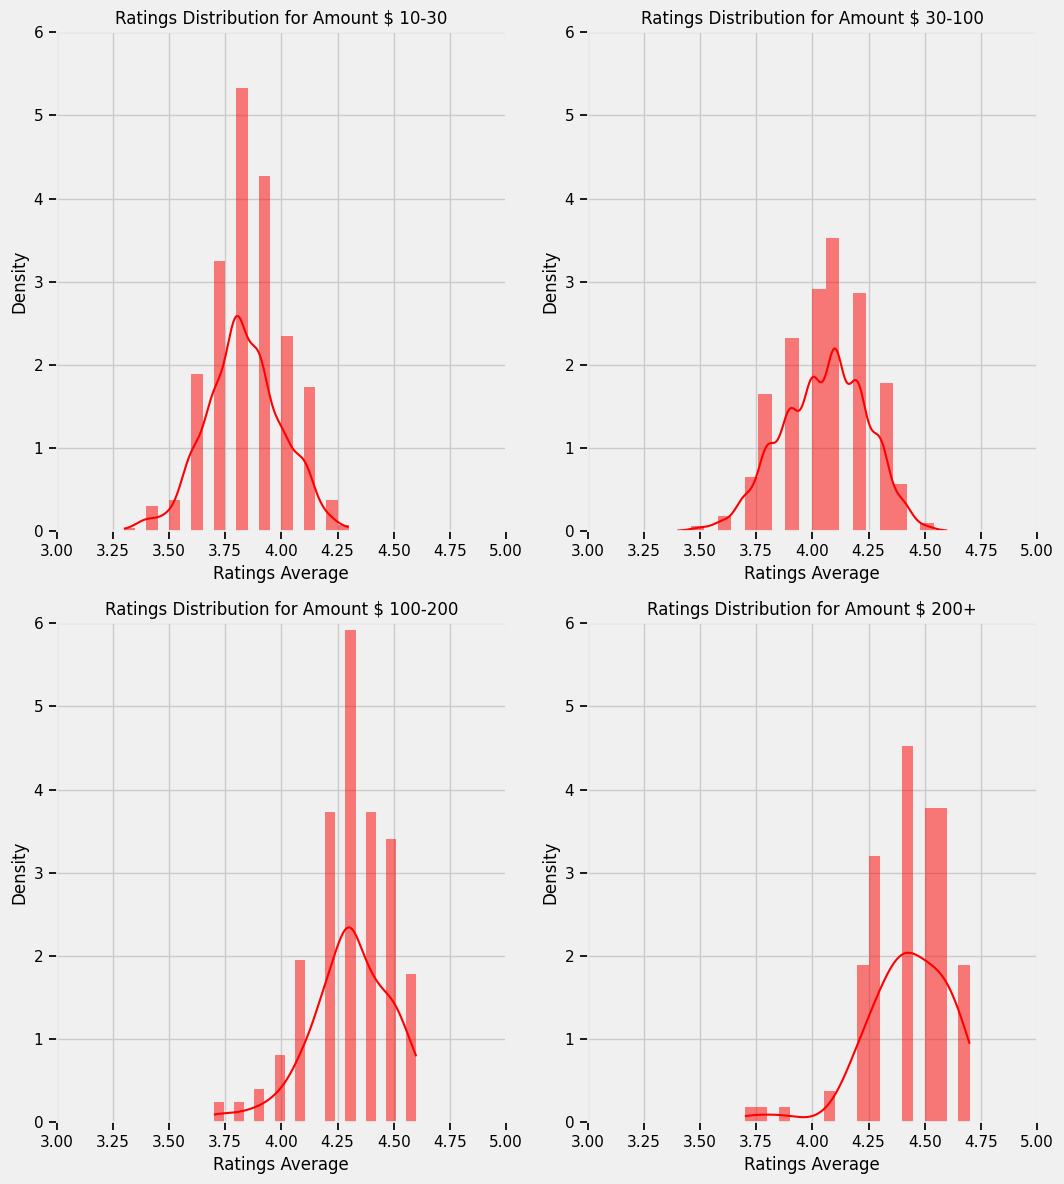

In [3]:


# Ensure 'amount' is numeric and handle NaN values
all_filtered_winebottle_v1['amount'] = pd.to_numeric(all_filtered_winebottle_v1['amount'], errors='coerce')
all_filtered_winebottle_v1_clean = all_filtered_winebottle_v1[all_filtered_winebottle_v1['amount'].notna()]  # Drop NaN rows

# Filter data for years between 2000 and 2024
all_filtered_winebottle_v1_clean = all_filtered_winebottle_v1_clean[(all_filtered_winebottle_v1_clean['year'] >= 2000) & (all_filtered_winebottle_v1_clean['year'] <= 2024)]

# Filter wines with at least 100 reviews
all_filtered_winebottle_v1_clean = all_filtered_winebottle_v1_clean[all_filtered_winebottle_v1_clean['reviews_count'] >= 100]

# Check distribution of 'amount'
amount_distribution = all_filtered_winebottle_v1_clean['amount'].describe()
print(f"Amount Distribution:\n{amount_distribution}")

# Define the amount ranges and corresponding labels
amount_ranges = [(10, 30), (30, 100), (100, 200), (200, float('inf'))]
range_labels = ['10-30', '30-100', '100-200', '200+']

# Create figure for subplots
plt.figure(figsize=(12, 12))

# Loop through each amount range to create subplots
for i, (min_amount, max_amount) in enumerate(amount_ranges):
    plt.subplot(2, 2, i + 1)  # Create a 2x2 grid of subplots
    
    # Filter data by amount range
    filtered_data = all_filtered_winebottle_v1_clean[(all_filtered_winebottle_v1_clean['amount'] >= min_amount) & (all_filtered_winebottle_v1_clean['amount'] < max_amount)]
    
    # Check if there is any data to plot
    if filtered_data.empty:
        plt.text(0.5, 0.5, 'No data to plot', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
        plt.title(f'No data in Amount Range {range_labels[i]}')
    else:
        # Plot histogram for ratings_average in each amount range
        sns.histplot(filtered_data['ratings_average'], kde=True, bins=20, color='red', stat='density', linewidth=0)
        
        # Add labels and title
        plt.xlabel('Ratings Average')
        plt.ylabel('Density')
        plt.title(f'Ratings Distribution for Amount $ {range_labels[i]}')

        # Set the x and y axis limits
        plt.xlim(3, 5)  # Set x-axis range
        plt.ylim(0, 6)  # Set y-axis range

    # Add grid
    plt.grid(True)

# Adjust layout for better visualization
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the legend
plt.show()


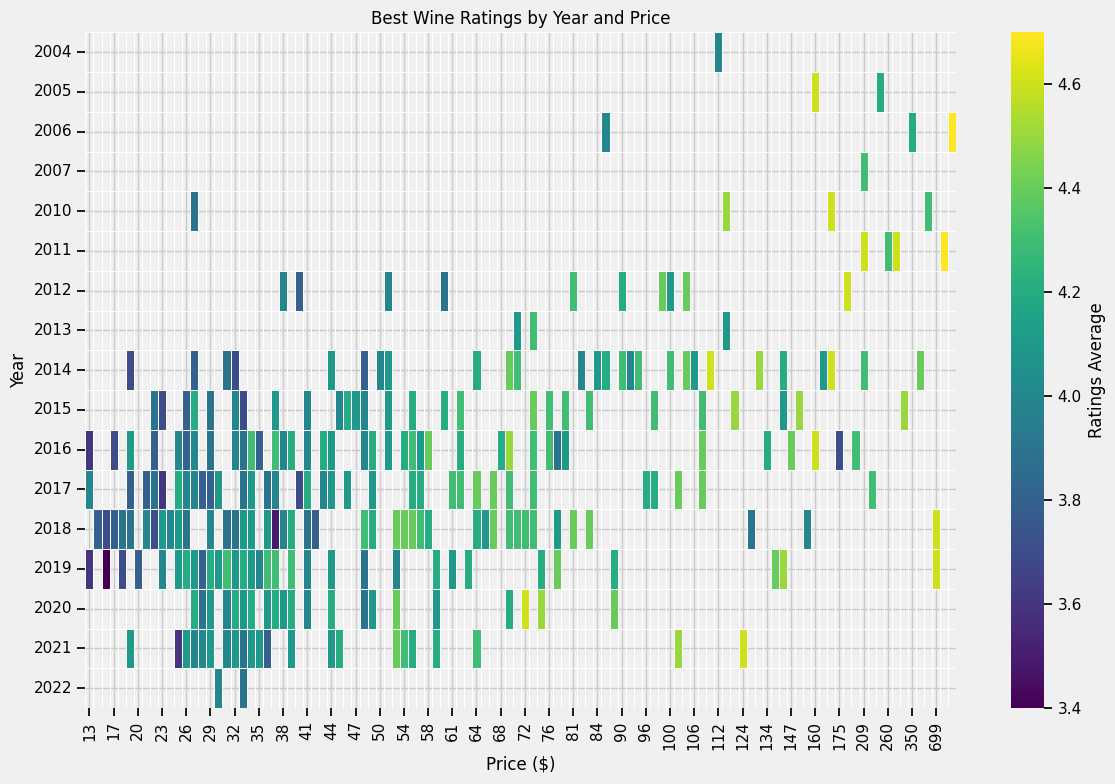

In [38]:
import numpy as np


# Handle NaN values in the 'amount' column
all_filtered_winebottle_v1['amount'] = pd.to_numeric(all_filtered_winebottle_v1['amount'], errors='coerce')  # Ensure 'amount' is numeric
all_filtered_winebottle_v1_clean = all_filtered_winebottle_v1[all_filtered_winebottle_v1['amount'].notna()]  # Drop rows where 'amount' is NaN
# Ensure 'year' and 'amount' are treated as whole numbers
all_filtered_winebottle_v1_clean['year'] = all_filtered_winebottle_v1_clean['year'].astype(int)
all_filtered_winebottle_v1_clean['amount'] = all_filtered_winebottle_v1_clean['amount'].astype(int)
# Filter data to only include years from 2000 to 2024
all_filtered_winebottle_v1_clean = all_filtered_winebottle_v1_clean[(all_filtered_winebottle_v1_clean['year'] >= 2000) & (all_filtered_winebottle_v1_clean['year'] <= 2024)]

# Filter wines with a minimum number of reviews (e.g., 100 reviews)
all_filtered_winebottle_v1_clean = all_filtered_winebottle_v1_clean[all_filtered_winebottle_v1_clean['reviews_count'] >= 500]
all_filtered_winebottle_v1_clean['amount_binned'] = pd.cut(all_filtered_winebottle_v1_clean['amount'], bins=range(0, all_filtered_winebottle_v1_clean['amount'].max() + 5, 5), right=False)

# Group by 'year' and 'amount', and get the maximum 'ratings_average' for each combination of 'year' and 'amount'
heatmap_data = all_filtered_winebottle_v1_clean.groupby(['year', 'amount'])['ratings_average'].max().unstack()

# Step 1: Generate x values between 0 and 700 with a step of 10

# Plot the heatmap
plt.figure(figsize=(12, 8))

sns.heatmap(heatmap_data, annot=False, fmt='.2f', cmap='viridis', cbar_kws={'label': 'Ratings Average'}, linewidths=0.5)

# Add labels and title
plt.title('Best Wine Ratings by Year and Price')
plt.xlabel('Price ($)')
plt.ylabel('Year')

# Show the plot
plt.tight_layout()
plt.show()


Best Wines in Each Price Range:
   price_range                                             name_x    year  \
0         0-30  Beringer Beringer Bros. Bourbon Barrel Aged Ca...  2016.0   
1         0-30                                 Alamos Malbec 2019  2019.0   
2         0-30                     Bread & Butter Pinot Noir 2021  2021.0   
3        30-60                                 Catena Malbec 2019  2019.0   
4        30-60                      Rutini Cabernet - Malbec 2016  2016.0   
5        30-60               Marqués de Riscal Rioja Reserva 2018  2018.0   
6       60-100    Austin Hope Austin Hope Cabernet Sauvignon 2020  2020.0   
7       60-100    Zenato Amarone della Valpolicella Classico 2017  2017.0   
8       60-100              Barbanera Gigino 80 Anniversario 2018  2018.0   
9      100-150               Bodegas Faustino I Gran Reserva 2004  2004.0   
10     100-150  Masi Costasera Amarone della Valpolicella Clas...  2016.0   
11     100-150           Hall Napa Valley Ca

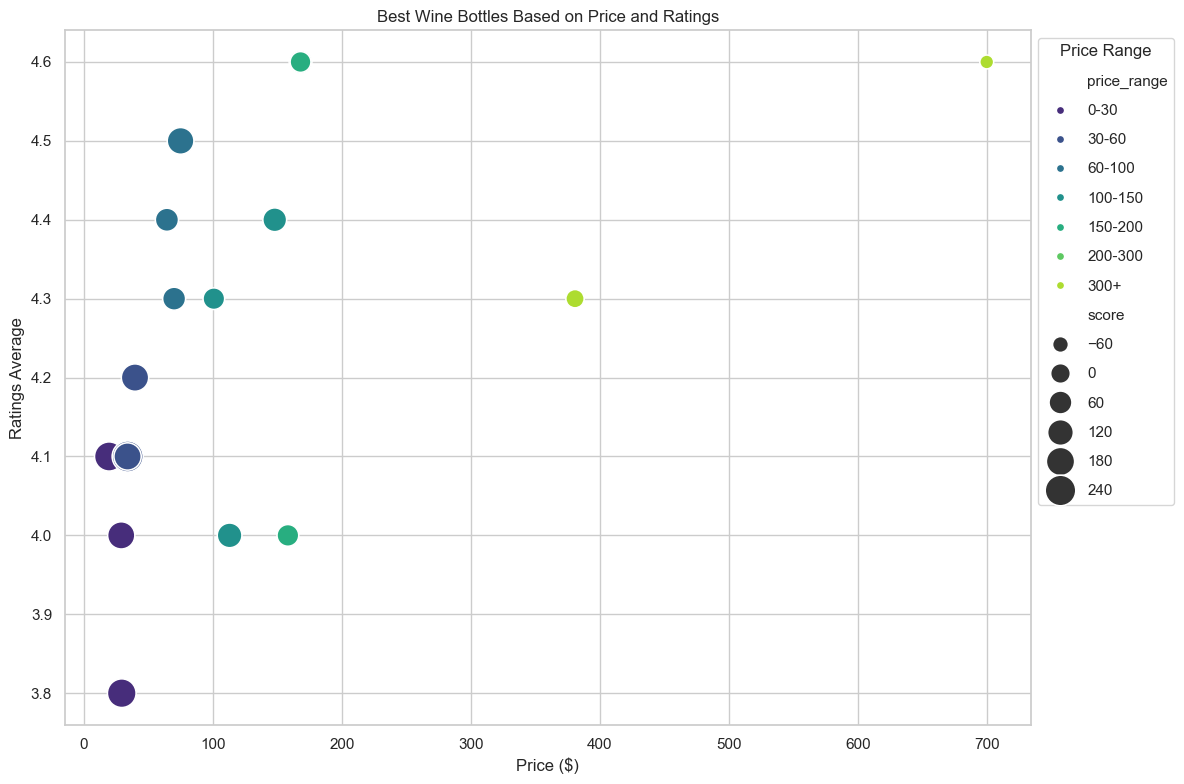

In [88]:

# Define the weights for each factor (adjust as needed)
w_rating = 0.4        # Rating still plays a role, moderate weight
w_acidity = 0.1       # Higher weight for acidity to capture freshness
w_tannin = 0.1       # Lower weight for tannin to focus on smoother wines
w_price = 0.2         # Keep price lower as a secondary factor
w_reviews_count = 0.05 # Reviews count can still be a factor, but less so
w_intensity = 0.1     # Moderate weight for intensity to reflect flavor richness
w_sweetness = 0.05    # Lower weight for sweetness since it's often not a key factor

# Normalize features like acidity, tannin, intensity, and sweetness
all_filtered_winebottle_v1_clean['Acidity_norm'] = (all_filtered_winebottle_v1_clean['Acidity'] - all_filtered_winebottle_v1_clean['Acidity'].min()) / (all_filtered_winebottle_v1_clean['Acidity'].max() - all_filtered_winebottle_v1_clean['Acidity'].min())
all_filtered_winebottle_v1_clean['Tannin_norm'] = (all_filtered_winebottle_v1_clean['Tannin'] - all_filtered_winebottle_v1_clean['Tannin'].min()) / (all_filtered_winebottle_v1_clean['Tannin'].max() - all_filtered_winebottle_v1_clean['Tannin'].min())
all_filtered_winebottle_v1_clean['Intensity_norm'] = (all_filtered_winebottle_v1_clean['Intensity'] - all_filtered_winebottle_v1_clean['Intensity'].min()) / (all_filtered_winebottle_v1_clean['Intensity'].max() - all_filtered_winebottle_v1_clean['Intensity'].min())

# Calculate the score for each wine based on the weights and normalized factors
all_filtered_winebottle_v1_clean['score'] = (
    w_rating * all_filtered_winebottle_v1_clean['ratings_average'] +
    w_acidity * all_filtered_winebottle_v1_clean['Acidity_norm'] +
    w_tannin * all_filtered_winebottle_v1_clean['Tannin_norm'] +
    w_price * (1 - all_filtered_winebottle_v1_clean['amount']) +  # Assuming lower price is better
    w_reviews_count * all_filtered_winebottle_v1_clean['reviews_count'] +  # Higher reviews count may indicate better reputation
    w_intensity * all_filtered_winebottle_v1_clean['Intensity_norm'] +  # Intensity can add to wine quality
    w_sweetness * all_filtered_winebottle_v1_clean['Sweetness']  # Sweetness can affect preference
)

# Define price ranges as bins
price_bins = [0, 30, 60, 100, 150, 200, 300, float('inf')]
price_labels = ['0-30', '30-60', '60-100', '100-150', '150-200', '200-300', '300+']

# Create a new column for the price range
all_filtered_winebottle_v1_clean['price_range'] = pd.cut(all_filtered_winebottle_v1_clean['amount'], bins=price_bins, labels=price_labels)

# Group by price range and sort each group by score, then pick the top wine(s) in each range
best_bottles_in_range = all_filtered_winebottle_v1_clean.groupby('price_range').apply(
    lambda x: x.sort_values(by='score', ascending=False).head(3)  # Show top 3 wines in each range
).reset_index(drop=True)

# Display the best wines in each price range
print("Best Wines in Each Price Range:")
print(best_bottles_in_range[['price_range', 'name_x', 'year', 'amount', 'Producer', 'WineType', 'ratings_average', 'Acidity', 'Tannin', 'reviews_count', 'Intensity', 'Sweetness', 'score']])
best_bottles_in_range.to_csv('best_wines_in_price_range.csv', index=False)
# Visualization: Plotting the best wines across price ranges
plt.figure(figsize=(12, 8))

# Scatter plot with hue for price range and size for score
sns.scatterplot(data=best_bottles_in_range, 
                x='amount', 
                y='ratings_average', 
                hue='price_range', 
                palette='viridis', 
                size='score', 
                sizes=(100, 500) 
                )

# Remove the 'score' from the legend by setting legend to 'brief' and hiding the 'size' legend
plt.legend(title='Price Range', loc='upper left', bbox_to_anchor=(1, 1), labelspacing=1)

# Adding titles and labels
plt.title('Best Wine Bottles Based on Price and Ratings')
plt.xlabel('Price ($)')
plt.ylabel('Ratings Average')
plt.tight_layout()

# Show the plot
plt.show()


Best Dry Wines in Each Price Range:
   price_range                                             name_x    year  \
0         0-30  Beringer Beringer Bros. Bourbon Barrel Aged Ca...  2016.0   
1         0-30                     Bread & Butter Pinot Noir 2021  2021.0   
2         0-30             Casa Ferreirinha Papa Figos Douro 2016  2016.0   
3        30-60                      Rutini Cabernet - Malbec 2016  2016.0   
4        30-60               Marqués de Riscal Rioja Reserva 2018  2018.0   
5        30-60            Bodegas Marqués de Cáceres Crianza 2017  2017.0   
6       60-100    Austin Hope Austin Hope Cabernet Sauvignon 2020  2020.0   
7       60-100              Barbanera Gigino 80 Anniversario 2018  2018.0   
8       60-100                      Faust Cabernet Sauvignon 2016  2016.0   
9      100-150               Bodegas Faustino I Gran Reserva 2004  2004.0   
10     100-150                           Montes Purple Angel 2015  2015.0   
11     100-150           Hall Napa Valle

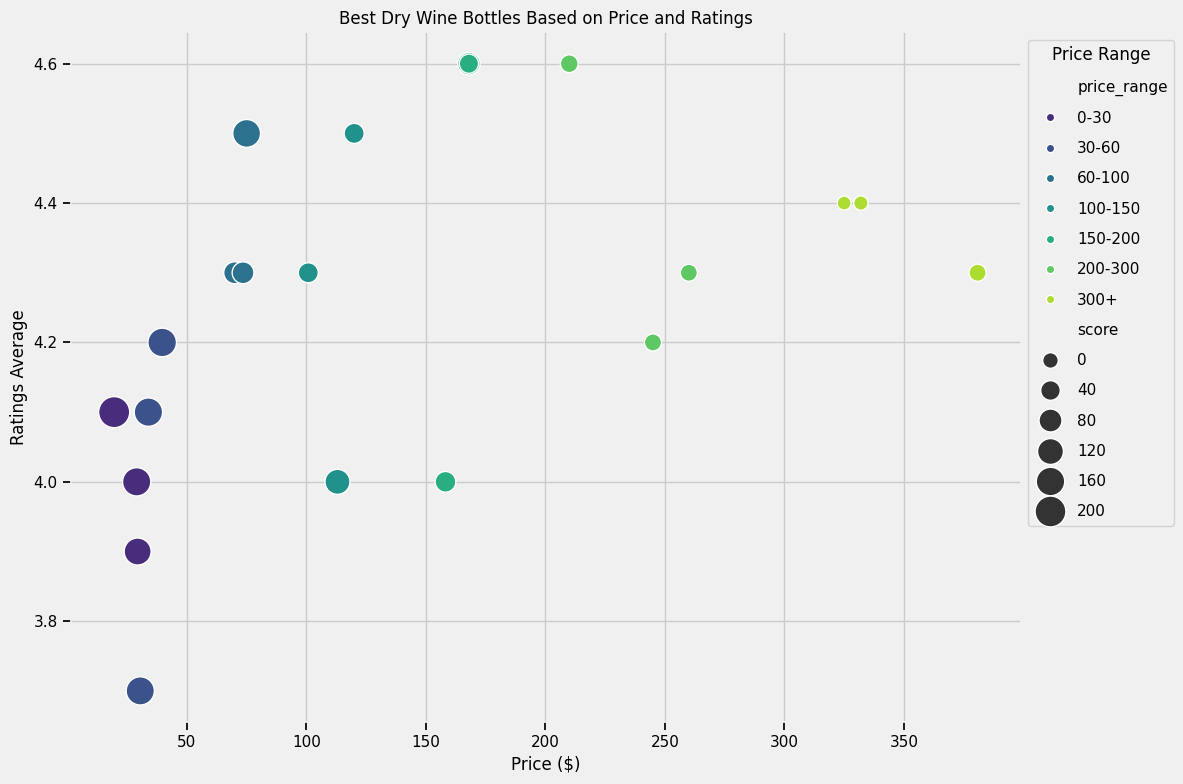

In [ ]:

# Filter for dry wines based on sweetness, acidity, and intensity
dry_wines = all_filtered_winebottle_v1_clean[
    (all_filtered_winebottle_v1_clean['Sweetness'] < 2) &        # Lower sweetness (e.g., less than 2 for dry wines)
    (all_filtered_winebottle_v1_clean['Acidity'] >= 3) &         # Moderate to high acidity (more refreshing for dry wines)
    (all_filtered_winebottle_v1_clean['Intensity'] >= 3)         # Moderate to high intensity for more complex dry wines
].copy()  # Make an explicit copy of the DataFrame to avoid warnings

# Check for and drop any rows with missing relevant columns
dry_wines = dry_wines.dropna(subset=['Sweetness', 'Acidity', 'Intensity', 'ratings_average', 'amount', 'Tannin', 'reviews_count'])

# Optional: If you want to focus on specific price ranges, you can add this as well
# dry_wines = dry_wines[dry_wines['price_range'].isin(['0-30', '30-60', '60-100'])]

# Define the weights for each factor (adjust as needed)
w_rating = 0.2        # Rating still plays a role, moderate weight
w_acidity = 0.25      # Higher weight for acidity to capture freshness of dry wines
w_tannin = 0.05       # Lower weight for tannin to focus on smoother wines
w_price = 0.1         # Keep price lower as a secondary factor
w_reviews_count = 0.05 # Reviews count can still be a factor, but less so
w_intensity = 0.2     # Moderate weight for intensity to reflect complexity in dry wines
w_sweetness = 0.1     # Lower weight for sweetness since dry wines are typically low in sweetness

# Normalize features like acidity, tannin, intensity, and sweetness
dry_wines['Acidity_norm'] = (dry_wines['Acidity'] - dry_wines['Acidity'].min()) / (dry_wines['Acidity'].max() - dry_wines['Acidity'].min())
dry_wines['Tannin_norm'] = (dry_wines['Tannin'] - dry_wines['Tannin'].min()) / (dry_wines['Tannin'].max() - dry_wines['Tannin'].min())
dry_wines['Intensity_norm'] = (dry_wines['Intensity'] - dry_wines['Intensity'].min()) / (dry_wines['Intensity'].max() - dry_wines['Intensity'].min())

# Calculate the score for each wine based on the weights and normalized factors
dry_wines['score'] = (
    w_rating * dry_wines['ratings_average'] +
    w_acidity * dry_wines['Acidity_norm'] +
    w_tannin * dry_wines['Tannin_norm'] +
    w_price * (1 - dry_wines['amount']) +  # Assuming lower price is better
    w_reviews_count * dry_wines['reviews_count'] +  # Higher reviews count may indicate better reputation
    w_intensity * dry_wines['Intensity_norm'] +  # Intensity can add to wine quality
    w_sweetness * dry_wines['Sweetness']  # Sweetness should be lower for dry wines
)

# Define price ranges as bins
price_bins = [0, 30, 60, 100, 150, 200, 300, float('inf')]
price_labels = ['0-30', '30-60', '60-100', '100-150', '150-200', '200-300', '300+']

# Create a new column for the price range
dry_wines['price_range'] = pd.cut(dry_wines['amount'], bins=price_bins, labels=price_labels)

# Group by price range and sort each group by score, then pick the top wine(s) in each range
best_bottles_in_range = dry_wines.groupby('price_range', observed=True).apply(
    lambda x: x.sort_values(by='score', ascending=False).head(3)  # Show top 3 wines in each range
).reset_index(drop=True)

# Display the best dry wines in each price range
print("Best Dry Wines in Each Price Range:")
print(best_bottles_in_range[['price_range', 'name_x', 'year', 'amount', 'ratings_average', 'Acidity', 'Tannin', 'reviews_count', 'Intensity', 'Sweetness', 'score']])
best_bottles_in_range.to_csv('best_Drywines_in_price_range.csv', index=False)
# Visualization: Plotting the best wines across price ranges
plt.figure(figsize=(12, 8))

# Scatter plot with hue for price range and size for score
sns.scatterplot(data=best_bottles_in_range, 
                x='amount', 
                y='ratings_average', 
                hue='price_range', 
                palette='viridis', 
                size='score', 
                sizes=(100, 500) 
                )

# Remove the 'score' from the legend by setting legend to 'brief' and hiding the 'size' legend
plt.legend(title='Price Range', loc='upper left', bbox_to_anchor=(1, 1), labelspacing=1)

# Adding titles and labels
plt.title('Best Dry Wine Bottles Based on Price and Ratings')
plt.xlabel('Price ($)')
plt.ylabel('Ratings Average')
plt.tight_layout()

# Show the plot
plt.show()


Best Sweet Wines in Each Price Range:
   price_range                                             name_x    year  \
0         0-30  Masca del Tacco Lu Rappaio Primitivo di Mandur...  2020.0   
1         0-30               Masca del Tacco Lu'Li Appassite 2019  2019.0   
2         0-30                             Cantele Primitivo 2016  2016.0   
3        30-60         Casalforte Amarone della Valpolicella 2015  2015.0   
4        30-60      Varvaglione Papale Primitivo di Manduria 2017  2017.0   
5        30-60  Luigi Righetti Capitel de Roari Amarone della ...  2016.0   
6       60-100    Zenato Amarone della Valpolicella Classico 2017  2017.0   
7       60-100  Domini Veneti Amarone della Valpolicella Class...  2015.0   
8       60-100  Masi Costasera Amarone della Valpolicella Clas...  2017.0   
9      100-150  Masi Costasera Amarone della Valpolicella Clas...  2016.0   
10     100-150  Zenato Amarone della Valpolicella Classico Ris...  2017.0   
11     100-150  Le Salette La Marega A

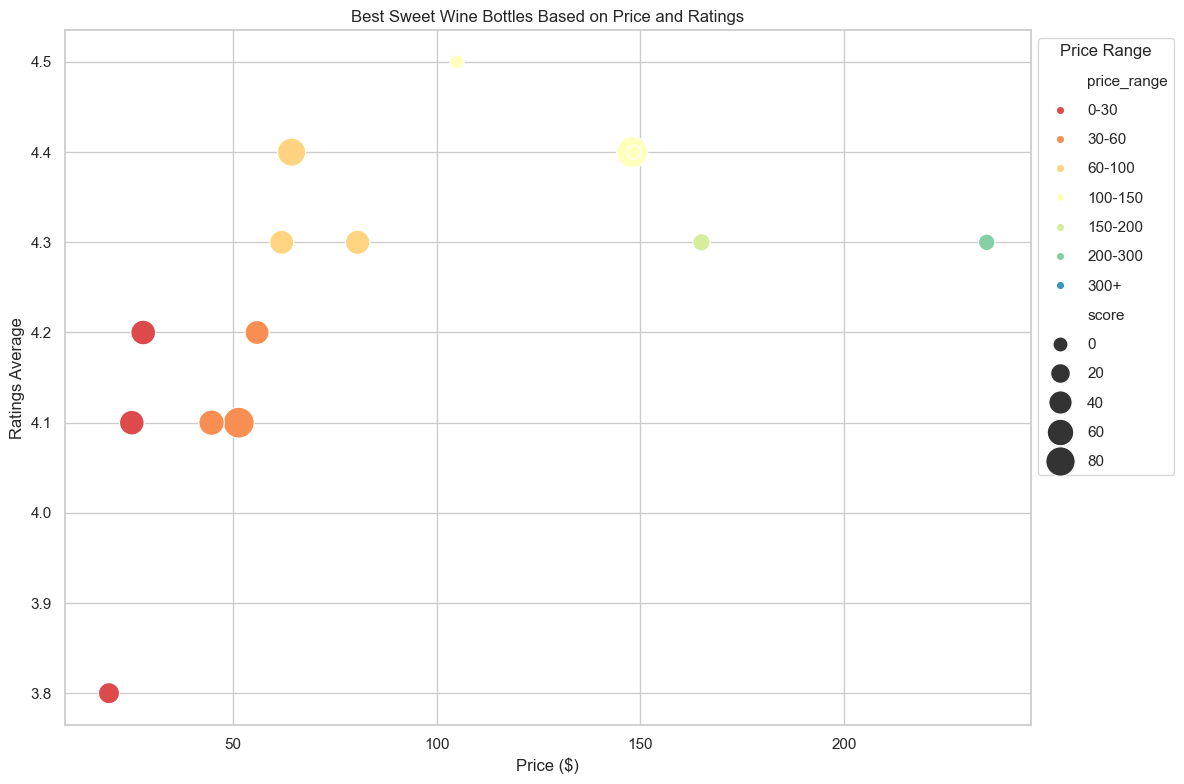

In [62]:
# Filter for sweet wines based on sweetness, acidity, and intensity
sweet_wines = all_filtered_winebottle_v1_clean[
    (all_filtered_winebottle_v1_clean['Sweetness'] > 2) &        # Higher sweetness for sweet wines
    (all_filtered_winebottle_v1_clean['Acidity'] <= 3.5) &       # Moderate to low acidity
    (all_filtered_winebottle_v1_clean['Intensity'] >= 3)         # Moderate to high intensity
].copy()  # Use .copy() to work with a new DataFrame

# Define the weights for each factor
w_rating = 0.2
w_acidity = 0.2
w_tannin = 0.05
w_price = 0.1
w_reviews_count = 0.05
w_intensity = 0.25
w_sweetness = 0.25

# Normalize features using .loc to avoid SettingWithCopyWarning
sweet_wines.loc[:, 'Acidity_norm'] = (
    sweet_wines['Acidity'] - sweet_wines['Acidity'].min()
) / (sweet_wines['Acidity'].max() - sweet_wines['Acidity'].min())

sweet_wines.loc[:, 'Tannin_norm'] = (
    sweet_wines['Tannin'] - sweet_wines['Tannin'].min()
) / (sweet_wines['Tannin'].max() - sweet_wines['Tannin'].min())

sweet_wines.loc[:, 'Intensity_norm'] = (
    sweet_wines['Intensity'] - sweet_wines['Intensity'].min()
) / (sweet_wines['Intensity'].max() - sweet_wines['Intensity'].min())

# Calculate scores
sweet_wines.loc[:, 'score'] = (
    w_rating * sweet_wines['ratings_average'] +
    w_acidity * sweet_wines['Acidity_norm'] +
    w_tannin * sweet_wines['Tannin_norm'] +
    w_price * (1 - sweet_wines['amount']) +  # Assuming lower price is better
    w_reviews_count * sweet_wines['reviews_count'] +
    w_intensity * sweet_wines['Intensity_norm'] +
    w_sweetness * sweet_wines['Sweetness']
)

# Define price ranges
price_bins = [0, 30, 60, 100, 150, 200, 300, float('inf')]
price_labels = ['0-30', '30-60', '60-100', '100-150', '150-200', '200-300', '300+']

# Add price range column
sweet_wines.loc[:, 'price_range'] = pd.cut(
    sweet_wines['amount'], bins=price_bins, labels=price_labels
)

# Group by price range and find the top wines in each range
best_sweet_bottles_in_range = sweet_wines.groupby(
    'price_range', observed=True, group_keys=False
).apply(lambda x: x.nlargest(3, 'score')).reset_index(drop=True)

# Display the best sweet wines in each price range
print("Best Sweet Wines in Each Price Range:")
print(best_sweet_bottles_in_range[[
    'price_range', 'name_x', 'year', 'amount', 'ratings_average',
    'Acidity', 'Tannin', 'reviews_count', 'Intensity', 'Sweetness', 'score'
]])
best_sweet_bottles_in_range.to_csv('best_Sweetwines_in_price_range.csv', index=False)
# Visualization: Plotting the best sweet wines across price ranges
plt.figure(figsize=(12, 8))

# Scatter plot with hue for price range and size for score
sns.scatterplot(
    data=best_sweet_bottles_in_range, 
    x='amount', 
    y='ratings_average', 
    hue='price_range', 
    palette='Spectral', 
    size='score', 
    sizes=(100, 500)
)

# Adjust legend and titles
plt.legend(title='Price Range', loc='upper left', bbox_to_anchor=(1, 1), labelspacing=1)
plt.title('Best Sweet Wine Bottles Based on Price and Ratings')
plt.xlabel('Price ($)')
plt.ylabel('Ratings Average')
plt.tight_layout()

# Show the plot
plt.show()


Best Medium Dry Wines in Each Price Range:
   price_range                                             name_x    year  \
0         0-30  Tenuta Sant'Antonio Monti Garbi Valpolicella R...  2018.0   
1         0-30  Masca del Tacco Lu Rappaio Primitivo di Mandur...  2020.0   
2         0-30               Masca del Tacco Lu'Li Appassite 2019  2019.0   
3        30-60  Clos de los Siete Clos de Los Siete (by Michel...  2019.0   
4        30-60  Tommasi Valpolicella Ripasso (Classico Superio...  2017.0   
5        30-60  Zenato Ripassa Valpolicella Ripasso Superiore ...  2019.0   
6       60-100                Occhipinti Il Frappato Sicilia 2018  2018.0   
7       60-100  Vigneti del Salento Vigne Vecchie Primitivo di...  2012.0   
8       60-100                Occhipinti Il Frappato Sicilia 2016  2016.0   
9      100-150  Cantine del Notaio La Firma Aglianico del Vult...  2013.0   
10     100-150  Louis M. Martini Monte Rosso Vineyard Gnarly V...  2014.0   
11     100-150  Cantine del Notai

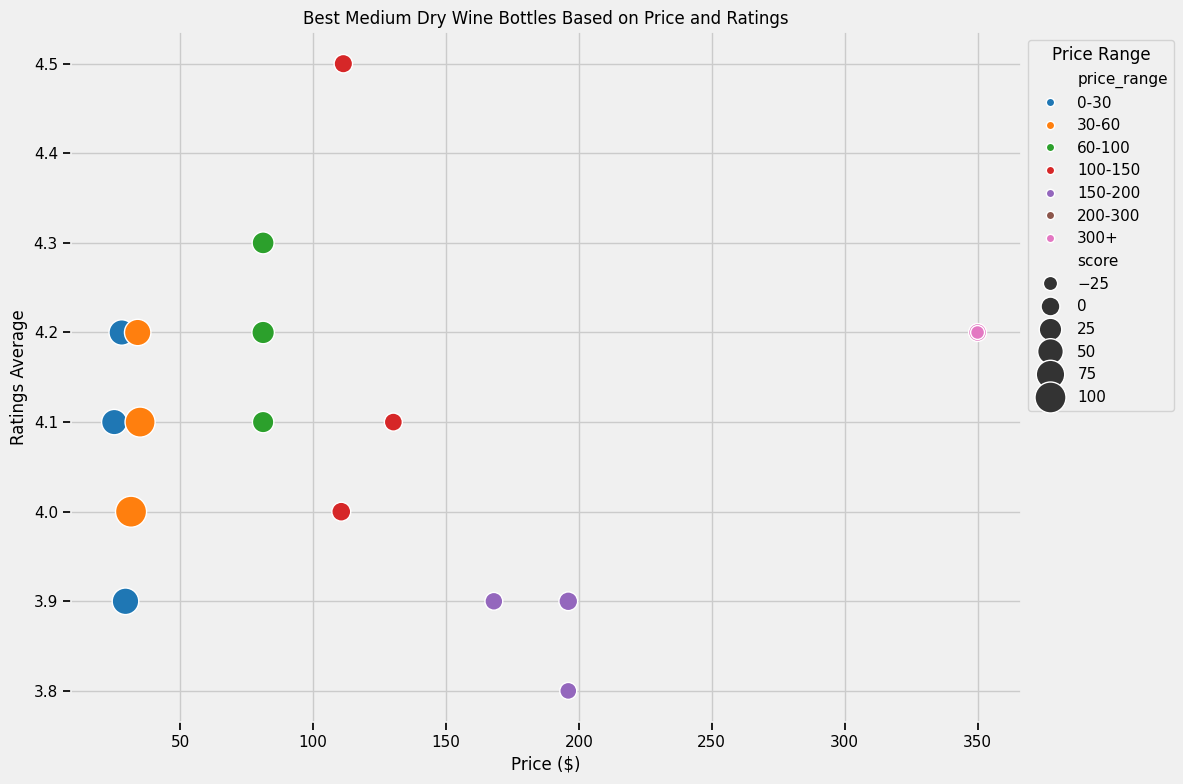

In [9]:

# Filter for medium dry wines based on sweetness, acidity, and intensity
medium_dry_wines = all_filtered_winebottle_v1_clean[
    (all_filtered_winebottle_v1_clean['Sweetness'] > 1.5) &  
    (all_filtered_winebottle_v1_clean['Sweetness'] <= 2.5) & 
    (all_filtered_winebottle_v1_clean['Acidity'] <= 3.5) &  
    (all_filtered_winebottle_v1_clean['Intensity'] >= 2)
].copy()  # Use .copy() to work with a new DataFrame

# Define weights for each factor
w_rating = 0.2
w_acidity = 0.2
w_tannin = 0.05
w_price = 0.1
w_reviews_count = 0.05
w_intensity = 0.25
w_sweetness = 0.25

# Normalize features using .loc to avoid SettingWithCopyWarning
medium_dry_wines.loc[:, 'Acidity_norm'] = (
    medium_dry_wines['Acidity'] - medium_dry_wines['Acidity'].min()
) / (medium_dry_wines['Acidity'].max() - medium_dry_wines['Acidity'].min())

medium_dry_wines.loc[:, 'Tannin_norm'] = (
    medium_dry_wines['Tannin'] - medium_dry_wines['Tannin'].min()
) / (medium_dry_wines['Tannin'].max() - medium_dry_wines['Tannin'].min())

medium_dry_wines.loc[:, 'Intensity_norm'] = (
    medium_dry_wines['Intensity'] - medium_dry_wines['Intensity'].min()
) / (medium_dry_wines['Intensity'].max() - medium_dry_wines['Intensity'].min())

# Calculate scores
medium_dry_wines.loc[:, 'score'] = (
    w_rating * medium_dry_wines['ratings_average'] +
    w_acidity * medium_dry_wines['Acidity_norm'] +
    w_tannin * medium_dry_wines['Tannin_norm'] +
    w_price * (1 - medium_dry_wines['amount']) +
    w_reviews_count * medium_dry_wines['reviews_count'] +
    w_intensity * medium_dry_wines['Intensity_norm'] +
    w_sweetness * medium_dry_wines['Sweetness']
)

# Define price ranges
price_bins = [0, 30, 60, 100, 150, 200, 300, float('inf')]
price_labels = ['0-30', '30-60', '60-100', '100-150', '150-200', '200-300', '300+']

# Add price range column
medium_dry_wines.loc[:, 'price_range'] = pd.cut(
    medium_dry_wines['amount'], bins=price_bins, labels=price_labels
)

# Group by price range and find the top wines in each range
best_medium_dry_bottles_in_range = medium_dry_wines.groupby(
    'price_range', observed=True, group_keys=False
).apply(lambda x: x.nlargest(3, 'score')).reset_index(drop=True)

# Display results
print("Best Medium Dry Wines in Each Price Range:")
print(best_medium_dry_bottles_in_range[[
    'price_range', 'name_x', 'year', 'amount', 'ratings_average',
    'Acidity', 'Tannin', 'reviews_count', 'Intensity', 'Sweetness', 'score'
]])
best_bottles_in_range.to_csv('best_MediumDrywines_in_price_range.csv', index=False)
# Visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=best_medium_dry_bottles_in_range, x='amount', y='ratings_average',
    hue='price_range', palette='tab10', size='score', sizes=(100, 500)
)
plt.legend(title='Price Range', loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Best Medium Dry Wine Bottles Based on Price and Ratings')
plt.xlabel('Price ($)')
plt.ylabel('Ratings Average')
plt.tight_layout()
plt.show()


In [ ]:

# Function to add a color column (you can adjust this based on any other feature you want to use for color)
def colorize_wine_data(df):
    # Optionally, use another feature like 'ratings_average' for color
    df_copy = df.copy()
    # Normalize or use another feature for color, for instance, ratings_average
    df_copy['color'] = df_copy['ratings_average']  # Example: color based on average ratings
    return df_copy

# Create the 3D scatter plot
fig = px.scatter_3d(
    colorize_wine_data(all_filtered_winebottle_v1),
    x='Intensity',   # x-axis: Intensity
    y='Sweetness',   # y-axis: Sweetness
    z='Acidity',     # z-axis: Acidity
    color='color',   # Color by 'color' column (e.g., based on 'ratings_average')
    range_x=[0, 5], # You can adjust these ranges depending on your data
    range_y=[0, 5], # Adjust the ranges for Sweetness and Acidity as needed
    range_z=[0, 5], 
    color_continuous_scale='plasma'  # Color scale (you can change this to other scales like 'Viridis')
)

# Show the plot
fig.show()


In [5]:
Top_Wines_df = pd.read_csv('Top_Wines_df.csv')
Top_Wines_df

Unnamed: 0           Producer  \
0            0           Beringer   
1            1     Bread & Butter   
2            2   Casa Ferreirinha   
3            3             Rutini   
4            4  Marqués de Riscal   
..         ...                ...   
79          79               Gaja   
80          80   Château Lagrange   
81          81               Muga   
82          82     Domaine Serene   
83          83    Mastroberardino   

                                             WineType             Region  \
0   Beringer Bros. Bourbon Barrel Aged Cabernet Sa...        Napa Valley   
1                                          Pinot Noir        Napa Valley   
2                                    Papa Figos Douro              Douro   
3                                   Cabernet - Malbec            Mendoza   
4                                       Rioja Reserva              Rioja   
..                                                ...                ...   
79                                    Dagromis Barolo             Barolo   
80                    Saint-Julien (Grand Cru Classé)       Saint-Julien   
81                            Prado Enea Gran Reserva              Rioja   
82                        Evenstad Reserve Pinot Noir  Willamette Valley   
83                             Taurasi Riserva Radici            Taurasi   

          Country  Year  Ratings_Average  reviews_count  amount  \
0   United States  2016              4.1         4089.0   19.57   
1   United States  2021              4.0         3171.0   28.99   
2        Portugal  2016              3.9         2767.0   29.39   
3       Argentina  2016              4.2         3286.0   39.66   
4           Spain  2018              4.1         3220.0   33.90   
..            ...   ...              ...            ...     ...   
79          Italy  2011              4.3          613.0  209.99   
80         France  2005              4.2          743.0  244.99   
81          Spain  2010              4.3         1022.0  380.80   
82  United States  2014              4.4          634.0  363.99   
83          Italy  2006              4.2          557.0  350.00   

                type  ...  December Cumulative Rain (mm)  \
0          price_qpr  ...                      89.600000   
1    best_user_rated  ...                      59.200000   
2   oldest_available  ...                     101.400000   
3    most_user_rated  ...                      56.799999   
4         top_listed  ...                     101.200000   
..               ...  ...                            ...   
79  oldest_available  ...                       3.600000   
80   critic_favorite  ...                     226.800001   
81  latest_available  ...                     180.000000   
82   most_user_rated  ...                     188.300001   
83   most_user_rated  ...                     101.400000   

    December Cumulative Snow (mm)  December Cumulative Precip (mm)  \
0                           13.16                       102.760000   
1                            0.00                        59.200000   
2                            0.00                       101.400000   
3                            0.00                        56.799999   
4                            0.00                       101.200000   
..                            ...                              ...   
79                           0.00                         3.600000   
80                          30.52                       257.320001   
81                          50.68                       230.680000   
82                           0.49                       188.790001   
83                           0.28                       101.680000   

    December Avg Cloud Cover (%)  December Max Wind Speed (Km/h)  \
0                      47.446237                       30.421598   
1                      47.979839                       46.265250   
2                      64.348118                       21.659916   
3      

In [6]:
# Create a map centered on the average latitude and longitude
m = folium.Map(location=[Top_Wines_df['Lat'].mean(), 
                         Top_Wines_df['Long'].mean()], zoom_start=5)

# Add wine locations to the map
for index, row in Top_Wines_df.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius=10,  # Adjust size of circle
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=f"{row['Producer']} - {row['amount']} - Ratings_Average: {row['Ratings_Average']}"
    ).add_to(m)

# Display the map
m



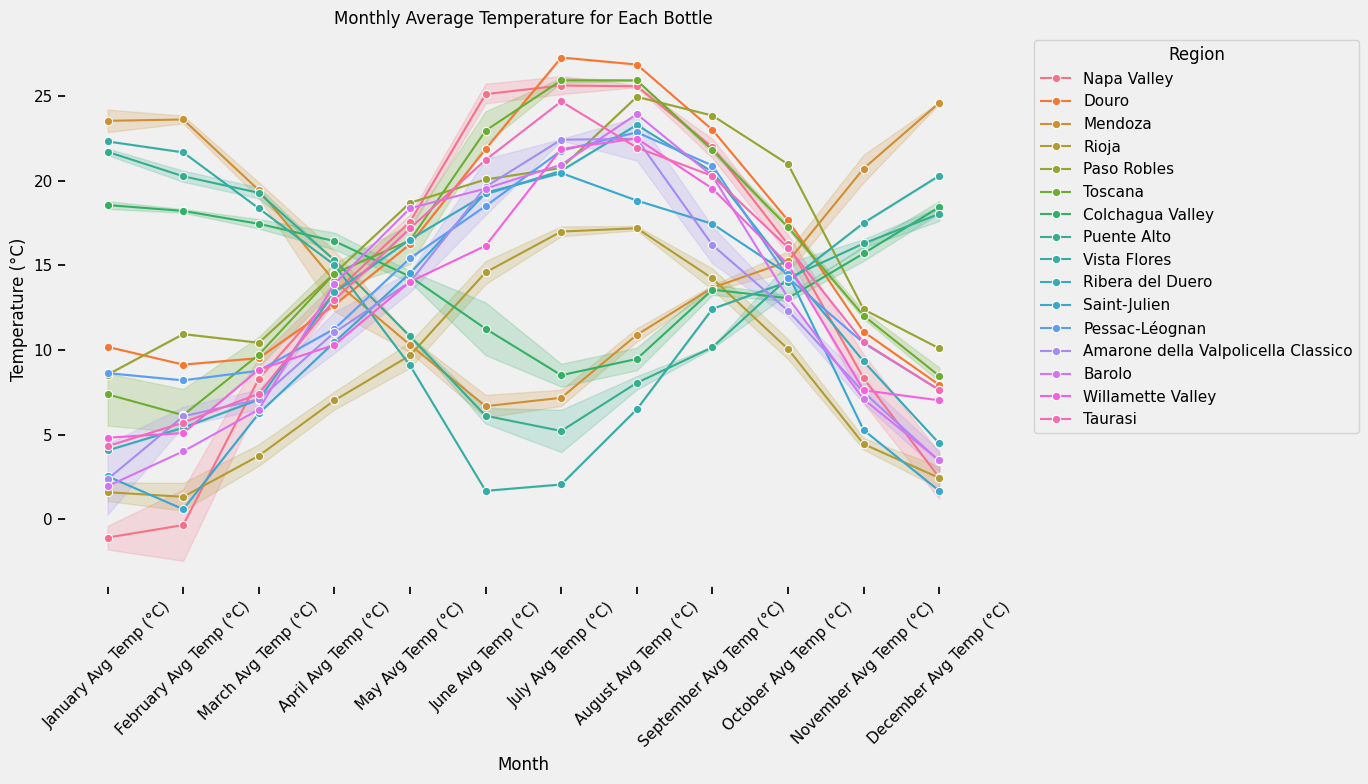

In [8]:
# Filter out monthly temperature columns and ensure proper data type
monthly_columns = [
    'January Avg Temp (°C)', 'February Avg Temp (°C)', 'March Avg Temp (°C)',
    'April Avg Temp (°C)', 'May Avg Temp (°C)', 'June Avg Temp (°C)',
    'July Avg Temp (°C)', 'August Avg Temp (°C)', 'September Avg Temp (°C)',
    'October Avg Temp (°C)', 'November Avg Temp (°C)', 'December Avg Temp (°C)'
]

# Melt the data for visualization (one row per bottle per month)
Top_Wines_df_melted = Top_Wines_df.melt(
    id_vars=['Region'],  # Replace with the column containing wine names
    value_vars=monthly_columns,
    var_name='Month',
    value_name='Avg Temp (°C)'
)

# Convert months to proper categorical order
Top_Wines_df_melted['Month'] = pd.Categorical(
    Top_Wines_df_melted['Month'], 
    categories=[
        'Ratings_Average','January Avg Temp (°C)', 'February Avg Temp (°C)', 'March Avg Temp (°C)',
        'April Avg Temp (°C)', 'May Avg Temp (°C)', 'June Avg Temp (°C)',
        'July Avg Temp (°C)', 'August Avg Temp (°C)', 'September Avg Temp (°C)',
        'October Avg Temp (°C)', 'November Avg Temp (°C)', 'December Avg Temp (°C)'
    ],
    ordered=True
)

# Rename months for cleaner display
Top_Wines_df_melted['Month'] = Top_Wines_df_melted['Month'].str.replace(' Avg Temp \\(°C\\)', '')

# Plot data
plt.figure(figsize=(14, 8))
sns.lineplot(data=Top_Wines_df_melted, x='Month', y='Avg Temp (°C)', hue='Region', marker='o')
plt.title('Monthly Average Temperature for Each Bottle')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()

